This notebook quantifies/ estimates teh projection of MSN using distribution of extra-somatic transcripts.

In [1]:
import numpy as np
import pandas as pd
import glob
import scipy 
from tqdm import tqdm 


- Load raw transcript files 

In [ ]:
fls = glob.glob(r'./Raw_custom_MERFISH_Imaging_data/20250626_hBG_2724_GPie/HumanBG_MERFISH_Filtered_Spots/Conv_zscan__*--spots.npz')
all_gns = np.loadtxt(r'./../../../analysis_notebooks/Final_codebook_BG_673gn_new.csv',dtype=str,delimiter=',')[1:,0] # get the full gn list form the codebook


xfov = []
header = list(np.load(fls[0])['header'])
icell_id = header.index('cell_id')
Mcts = []
for fl in tqdm(fls[::]):
    XF = np.load(fl)['XF']
    icell = XF[:,icell_id]
    genes_ = np.load(fl)['genes'][icell == 0]
    gns,cts = np.unique(np.concatenate([genes_,all_gns]), return_counts=True)
    xfov.append(XF[0][-2:]) # xfov, yfov i.e. global position of the fov center
    Mcts.append(cts)


100%|██████████| 5891/5891 [05:03<00:00, 19.41it/s]


- Load the adata 

In [ ]:
import scanpy as sc
adata = sc.read_h5ad(r'./../MERFISH_adata_QC/mapmycell_annotated_adata/MER4_Gpe_Gpi_2724__MERFISH_annotated.h5ad')


In [4]:
adata

AnnData object with n_obs × n_vars = 977764 × 673
    obs: 'volm', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'leiden', 'Neighborhood_label', 'Neighborhood_name', 'Neighborhood_bootstrapping_probability', 'Class_label', 'Class_name', 'Class_bootstrapping_probability', 'Subclass_label', 'Subclass_name', 'Subclass_bootstrapping_probability', 'Group_label', 'Group_name', 'Group_bootstrapping_probability', 'Cluster_label', 'Cluster_name', 'Cluster_alias', 'Cluster_bootstrapping_probability'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'Ensemble_ID'
    uns: 'Class_name_colors', 'Subclass_name_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'umap'
    obsm: 'X_raw', 'X_spatial', 'X_umap'
    layers: 'X_raw'
    obsp: 'connectivities', 

- Normalize the count

In [5]:
# replace count by raw count 
adata.X = adata.layers['X_raw'].copy()

In [5]:
# Normalize by volume
med_volm = np.median(adata.obs['volm'])
temp = adata.X.astype('float').copy()
temp /= adata.obs['volm'].values[:,np.newaxis]
temp *= med_volm
adata.X  = temp

# Normlize count 
target_sum  = np.median(np.array(adata.X.sum(axis=-1)))
sc.pp.normalize_total(adata, target_sum=target_sum)
sc.pp.log1p(adata)

# z-score count matrix 
# sc.pp.scale(adata, max_value=10)

### 1. Spatial plot for correlaton of ambient RNA/transcript count with the differential enrichement level of  genes between STR D2 Matrix MSN and  STR D1 Matrix MSN

1. Enrichment of STRd D2 Matrix MSN RNA

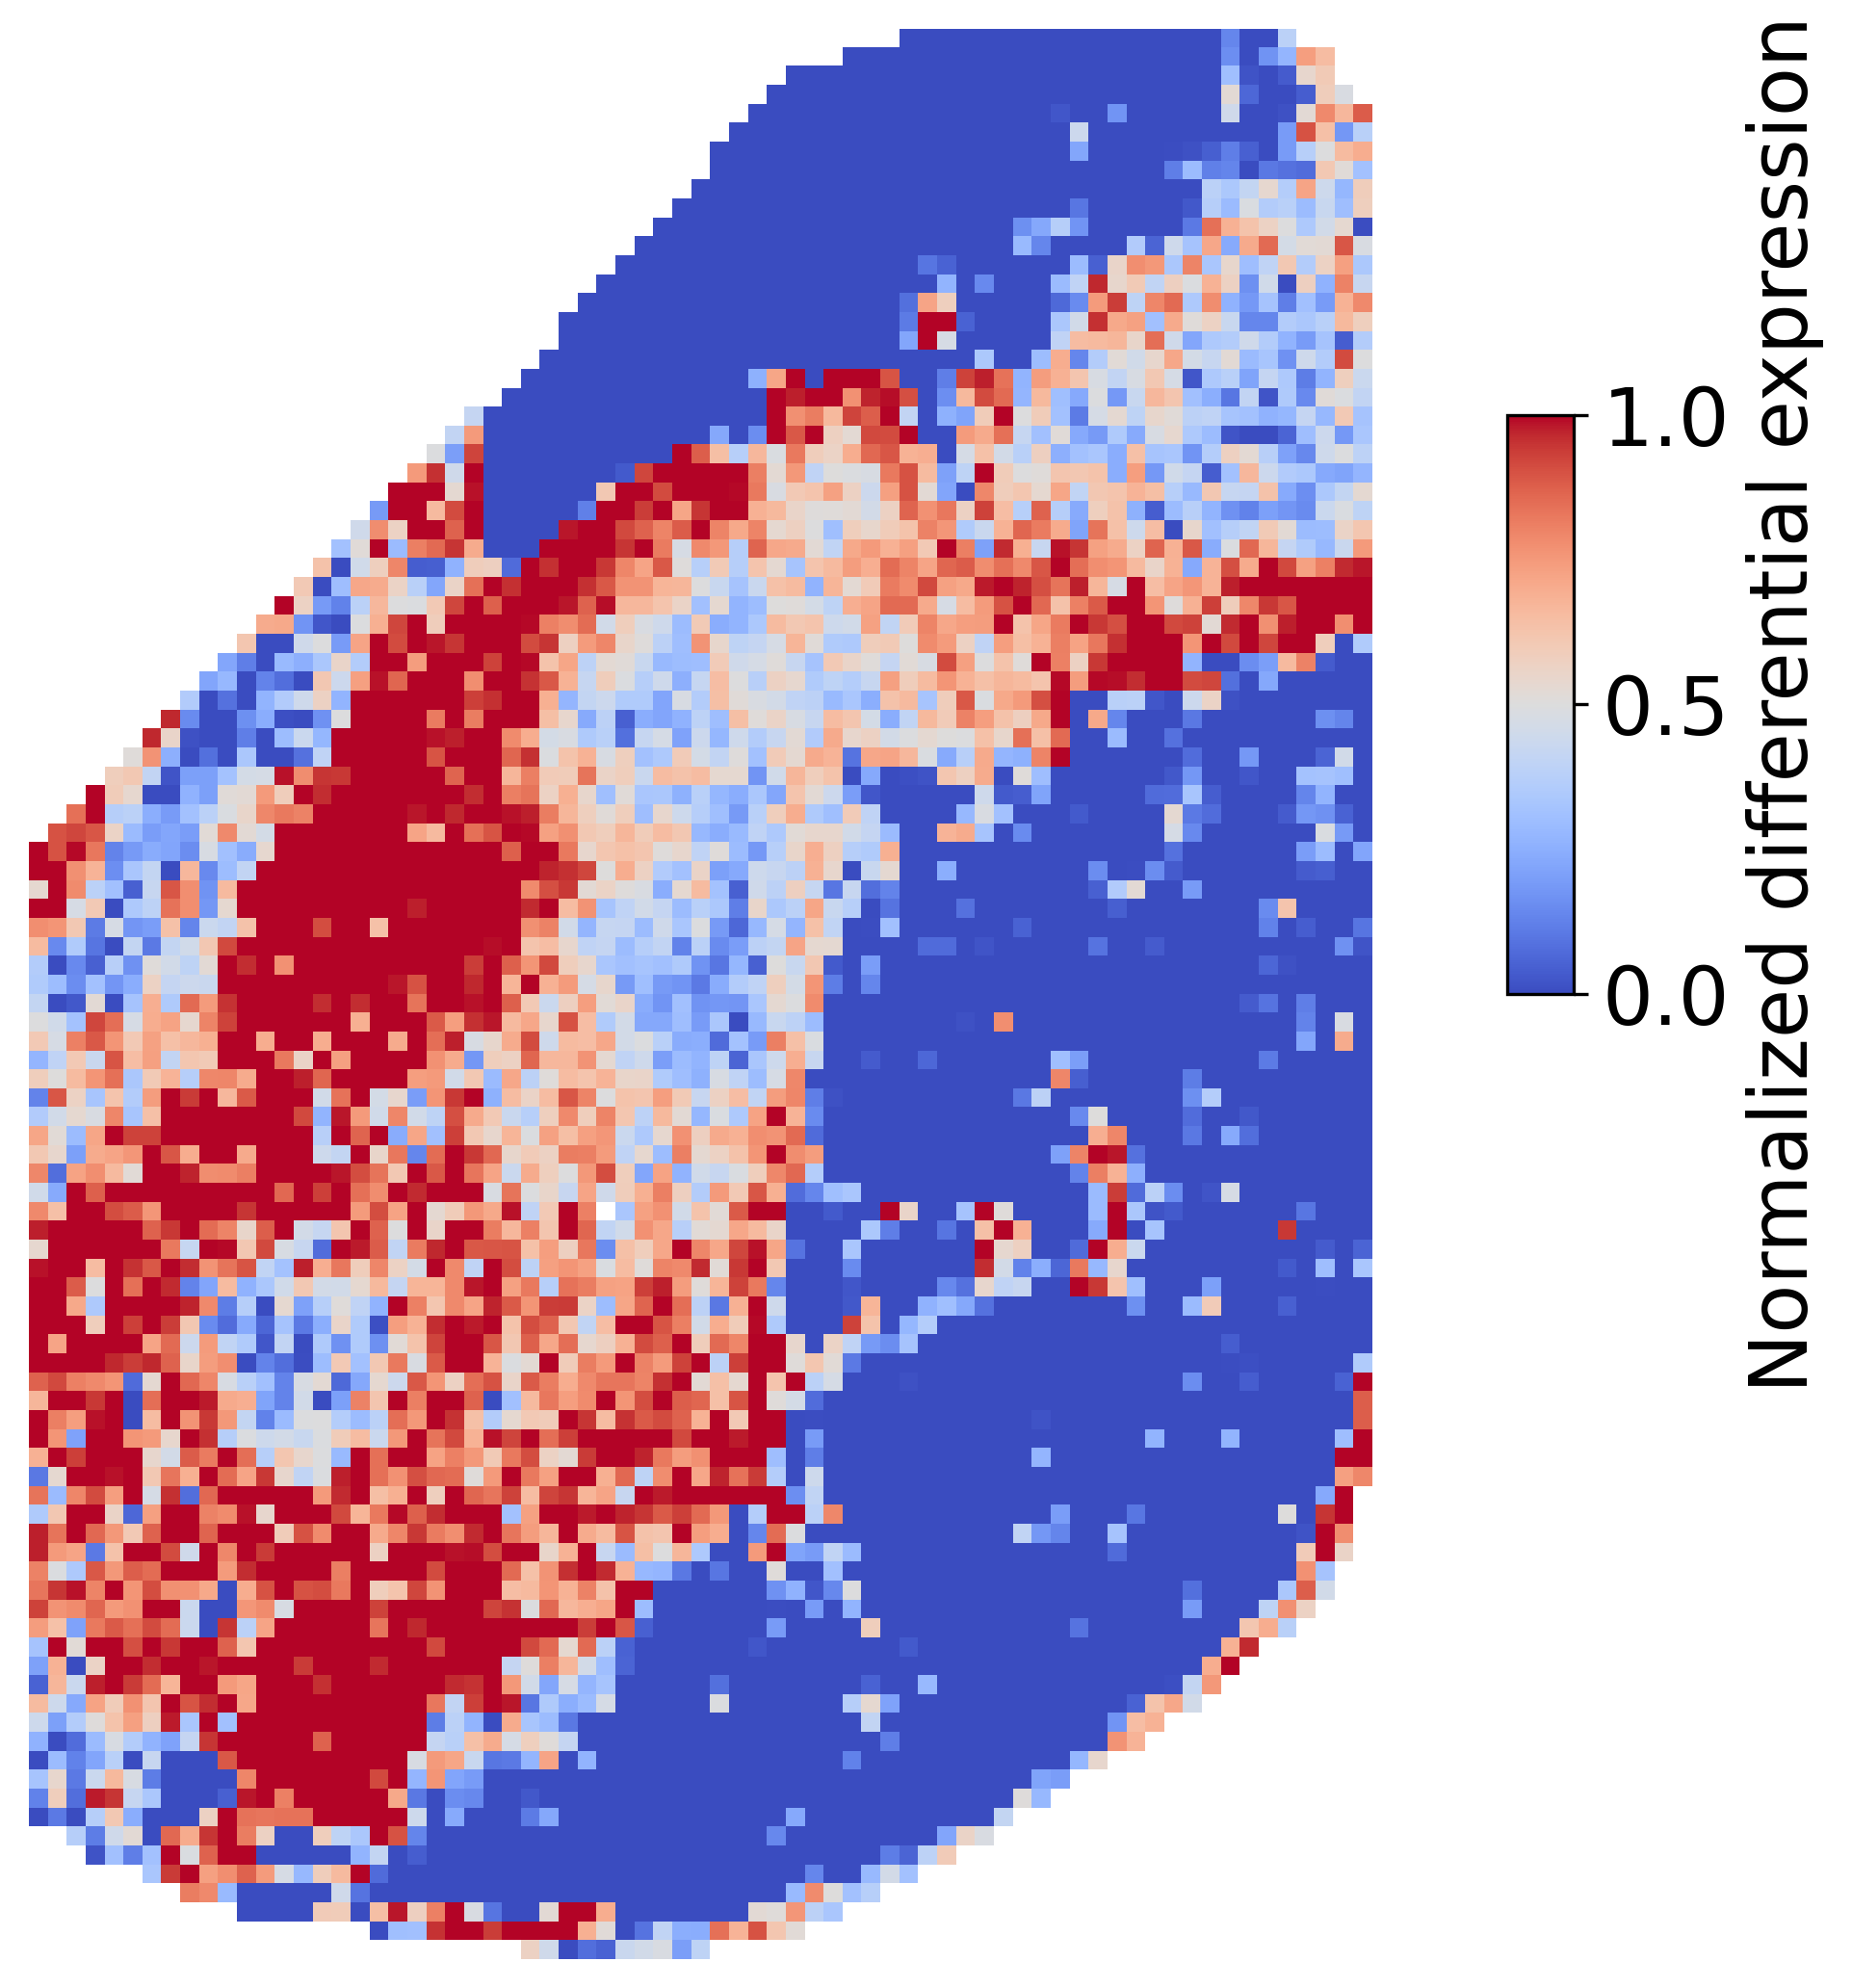

In [12]:
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt

mpl.rcParams['font.size'] = 20


keep_nonBlank = ['blank' not in gn.lower() for gn in gns]

gns_order = gns[keep_nonBlank].copy()
xfov = np.array(xfov)
XfovT = np.round(xfov/296.9).astype(int) # 296.9 is the  width of the fov
XfovT = XfovT-np.min(XfovT,axis=0)

Mcts_array  = np.array(Mcts)[:,keep_nonBlank]
Mlog = np.log(Mcts_array) 
Mlog = Mlog-np.mean(Mlog,axis=-1)[:,np.newaxis] # normalize across genes
Mlog = Mlog-np.mean(Mlog,axis=0)[np.newaxis,:] # normalize across FOVS

mn_all = np.mean(adata[:,gns_order].X,axis=0)

e1 = 'STRd D2 Matrix MSN'
e2 = 'STRd D1 Matrix MSN'


meanDH = np.mean(adata[:,gns_order][adata.obs['Group_name']== e1].X,axis=0)-mn_all
meanDHC= np.mean(adata[:,gns_order][adata.obs['Group_name']== e2].X,axis=0)-mn_all


Mloggn=np.dot(Mlog,meanDH-meanDHC)
mgn,Mgn = np.percentile(Mloggn,5),np.percentile(Mloggn,95)

def get_col(tv):
    cs = []
    for t in tv:
        if t<0.5: 
            t= 2*t
            c=np.array([1,0,1])*(1-t)+t*np.array([0,0,0])
        else:
            t=(t-0.5)*2
            c=np.array([0,0,0])*(1-t)+t*np.array([0,1,0])
        cs.append(c)
    return np.array(cs)

mgn,Mgn=-1,3
colgn = mpl.cm.coolwarm(np.clip((Mloggn-mgn)/(Mgn-mgn),0,1))[:,:3]

# colgn = get_col(np.clip((Mloggn-mgn)/(Mgn-mgn),0,1))
imgn = np.ones(list(np.max(XfovT,axis=0)+1)+[3])
imgn[tuple(XfovT.T)]=colgn[:,:3]

fig,ax = plt.subplots(1,1, dpi = 300, figsize = (6,9))
hd = ax.imshow(imgn)
# plt.colorbar(hd)
ax.set_axis_off()
ax.invert_yaxis()


# add colorbar
bbox = ax.get_position()
ax_cbar = fig.add_axes([bbox.xmin + 1.1*bbox.width, bbox.ymin + 0.5*bbox.height, 0.05*bbox.width, 0.3*bbox.height])

colorNorm = np.clip((Mloggn-mgn)/(Mgn-mgn),0,1)
cmap = mpl.cm.coolwarm
norm = mpl.colors.Normalize(vmin=colorNorm.min(), vmax=colorNorm.max())

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax_cbar, label='Normalized differential expression')

plt.savefig(r'./figures/Donor_2427_posterior_D2Matrix_enrichment_wrt_D1Matrix.png',bbox_inches = 'tight')
plt.savefig(r'./figures/Donor_2427_posterior_D2Matrix_enrichment_wrt_D1Matrix.tif',bbox_inches = 'tight')



plt.show()

2. Enrichment of STRd D1 Matrix MSN

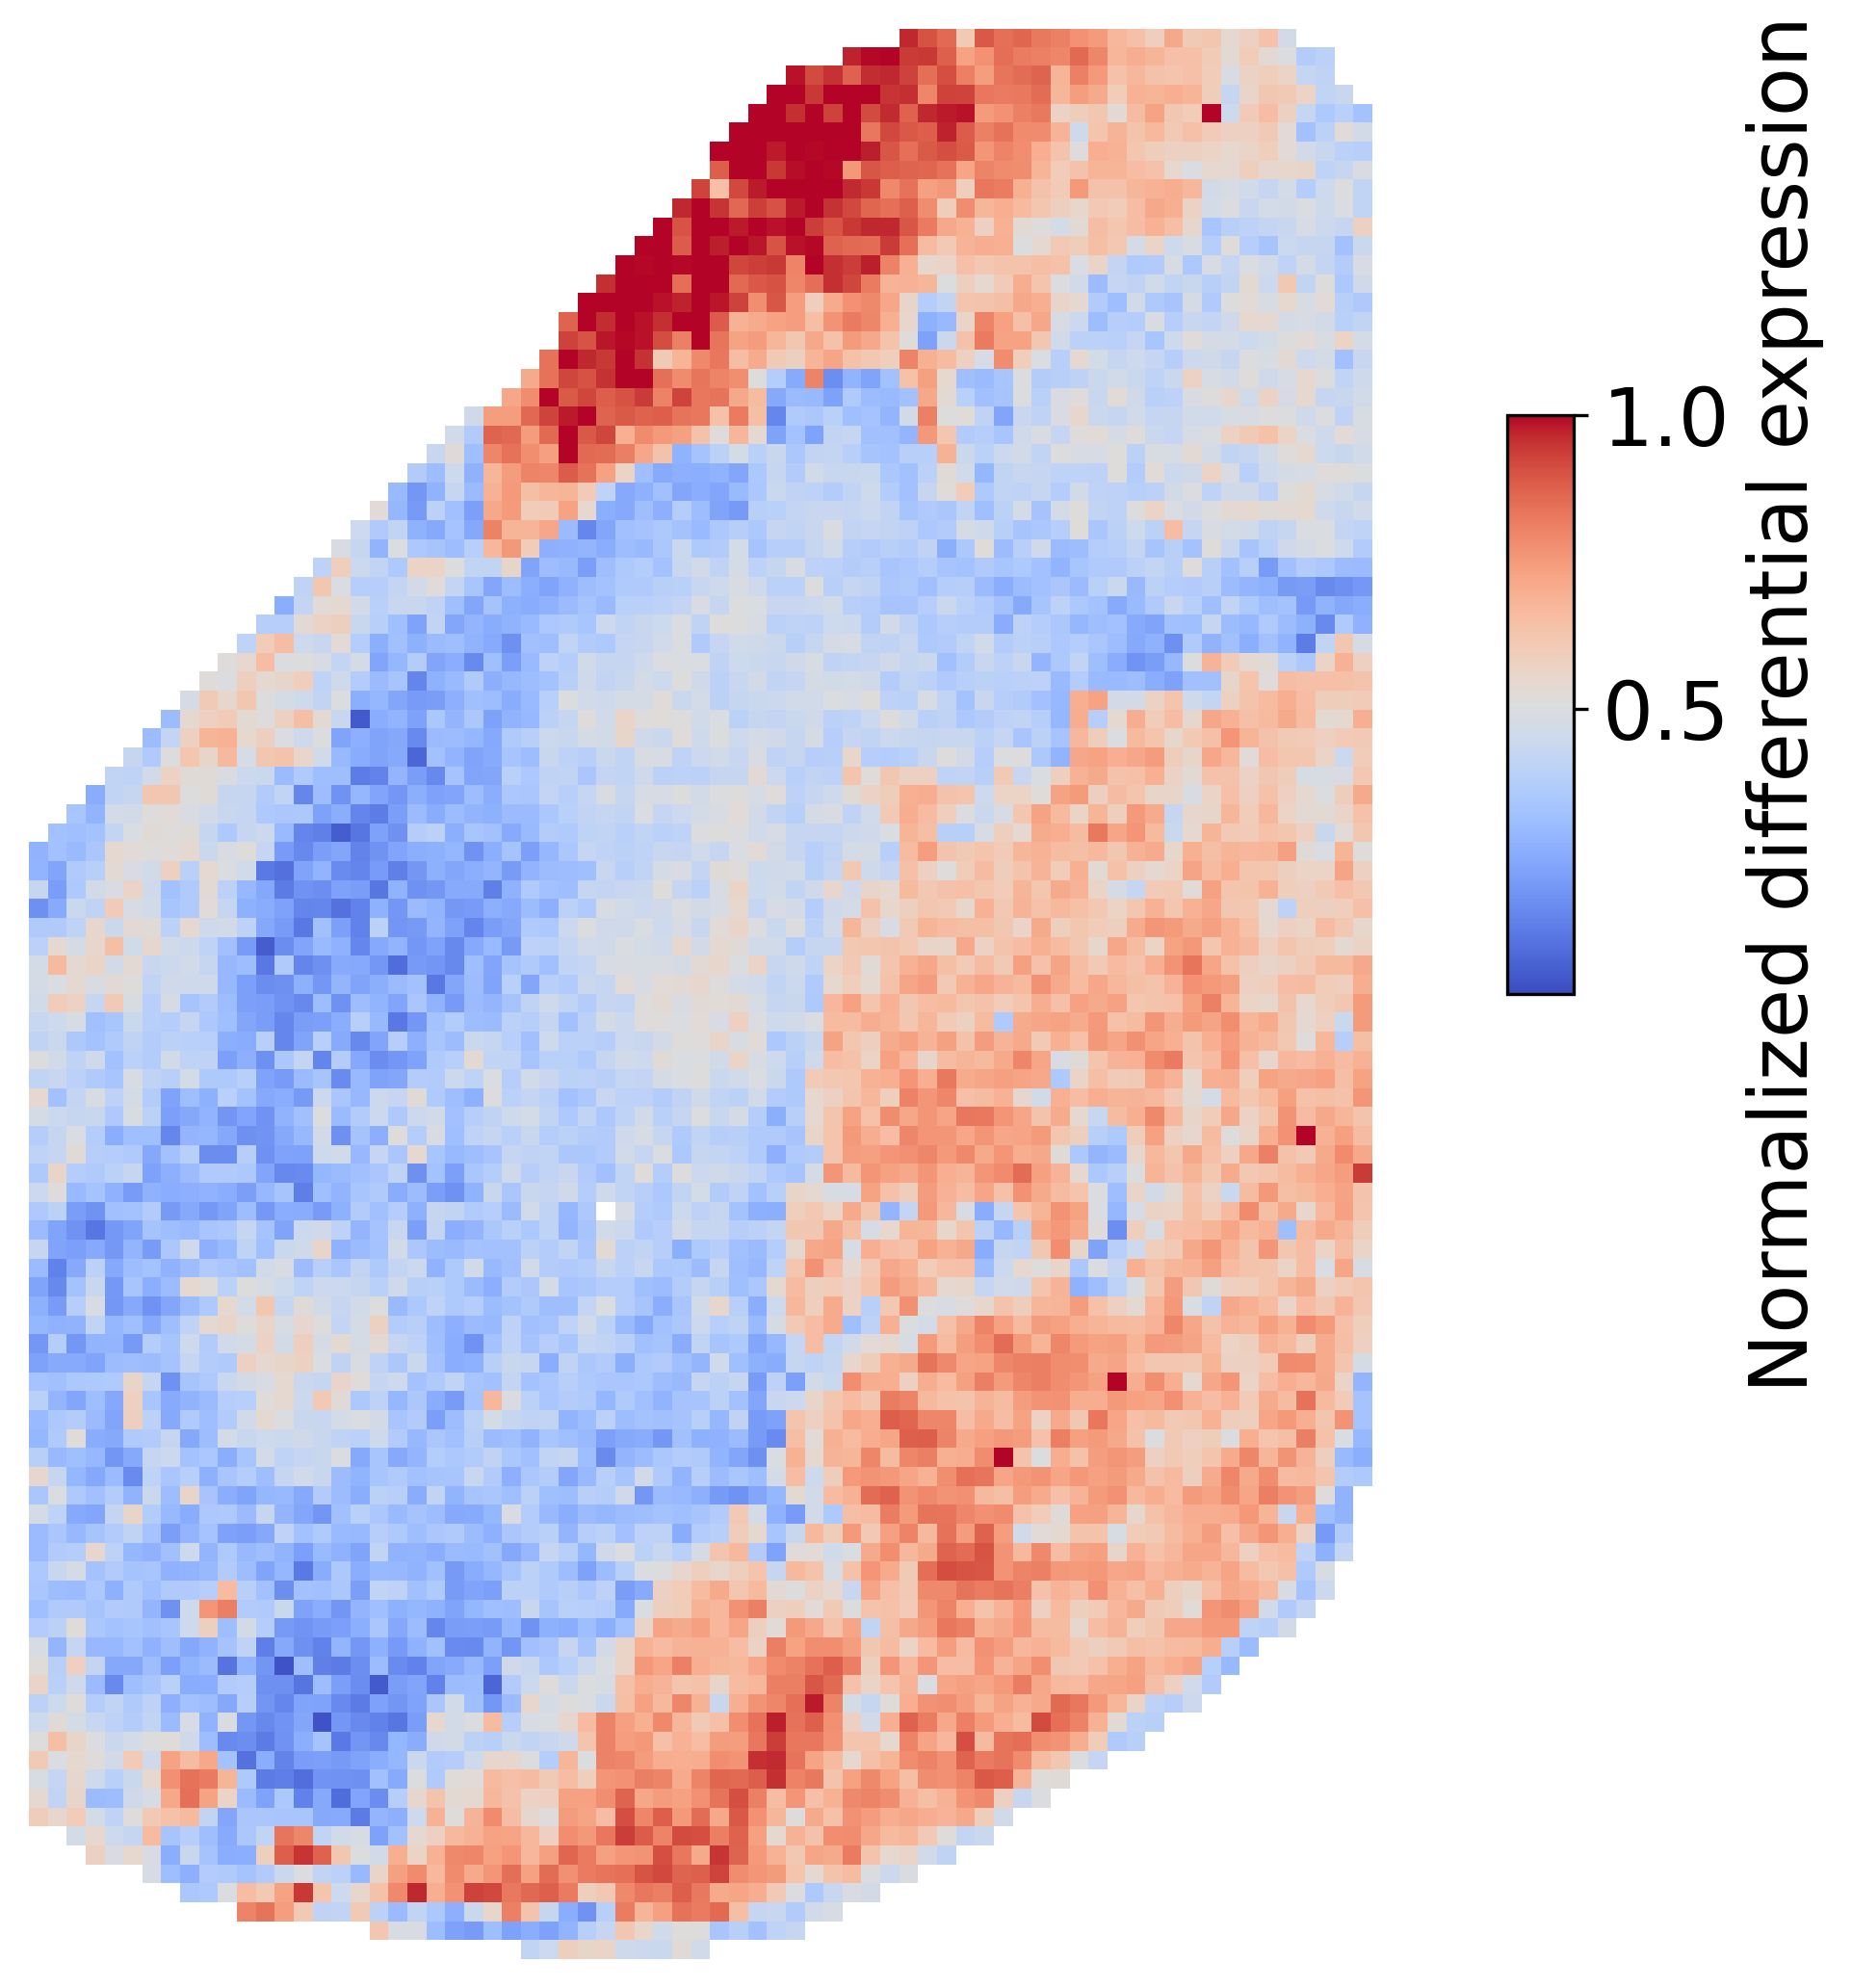

In [19]:
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt

mpl.rcParams['font.size'] = 20

keep_nonBlank = ['blank' not in gn.lower() for gn in gns]

gns_order = gns[keep_nonBlank].copy()
xfov = np.array(xfov)
XfovT = np.round(xfov/296.9).astype(int) # 296.9 is the  width of the fov
XfovT = XfovT-np.min(XfovT,axis=0)

Mcts_array  = np.array(Mcts)[:,keep_nonBlank]
Mlog = np.log(Mcts_array) 
Mlog = Mlog-np.mean(Mlog,axis=-1)[:,np.newaxis] # normalize across genes
Mlog = Mlog-np.mean(Mlog,axis=0)[np.newaxis,:] # normalize across FOVS

mn_all = np.mean(adata[:,gns_order].X,axis=0)

e1 = 'STRd D1 Matrix MSN'
e2 = 'STRd D2 Matrix MSN'


meanDH = np.mean(adata[:,gns_order][adata.obs['Group_name']== e1].X,axis=0)-mn_all
meanDHC= np.mean(adata[:,gns_order][adata.obs['Group_name']== e2].X,axis=0)-mn_all


Mloggn=np.dot(Mlog,meanDH-meanDHC)
mgn,Mgn = np.percentile(Mloggn,5),np.percentile(Mloggn,95)

def get_col(tv):
    cs = []
    for t in tv:
        if t<0.5: 
            t= 2*t
            c=np.array([1,0,1])*(1-t)+t*np.array([0,0,0])
        else:
            t=(t-0.5)*2
            c=np.array([0,0,0])*(1-t)+t*np.array([0,1,0])
        cs.append(c)
    return np.array(cs)

mgn,Mgn=-7,7
colgn = mpl.cm.coolwarm(np.clip((Mloggn-mgn)/(Mgn-mgn),0,1))[:,:3]

# colgn = get_col(np.clip((Mloggn-mgn)/(Mgn-mgn),0,1))
imgn = np.ones(list(np.max(XfovT,axis=0)+1)+[3])
imgn[tuple(XfovT.T)]=colgn[:,:3]

fig,ax = plt.subplots(1,1, dpi = 300, figsize = (6,9))
hd = ax.imshow(imgn)
# plt.colorbar(hd)
ax.set_axis_off()
ax.invert_yaxis()

# add colorbar
bbox = ax.get_position()
ax_cbar = fig.add_axes([bbox.xmin + 1.1*bbox.width, bbox.ymin + 0.5*bbox.height, 0.05*bbox.width, 0.3*bbox.height])

colorNorm = np.clip((Mloggn-mgn)/(Mgn-mgn),0,1)
cmap = mpl.cm.coolwarm
norm = mpl.colors.Normalize(vmin=colorNorm.min(), vmax=colorNorm.max())

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax_cbar, label='Normalized differential expression')

# plt.savefig(r'./figures/Donor_2427_posterior_D1Matrix_enrichment_wrt_D2Matrix.png',bbox_inches = 'tight')
# plt.savefig(r'./figures/Donor_2427_posterior_D1Matrix_enrichment_wrt_D2Matrix.tif',bbox_inches = 'tight')



plt.show()